In [1]:
pip install numpy pandas torch matplotlib seaborn emoji nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 24.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

Read the Data in

In [3]:
full_cleaned_df = pd.read_csv('https://github.com/rrandev03/NLP_Final/raw/refs/heads/main/100_data/102_processed/full_cleaned_df.csv')

Importing Transformers

In [4]:
#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel, TFBertForSequenceClassification
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel, TFRobertaForSequenceClassification

In [5]:
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

token_lens = []

for txt in full_cleaned_df['Cleaned_Tweets'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

max_len=np.max(token_lens)
print(f"MAX TOKENIZED SENTENCE LENGTH FOR TRAINING DATA: {max_len}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

MAX TOKENIZED SENTENCE LENGTH FOR TRAINING DATA: 78


In [6]:
full_cleaned_df = full_cleaned_df.sample(frac=1).reset_index(drop=True)

Tweet Label Column Analysis

In [7]:
full_cleaned_df['Labels'].value_counts()


,count
Labels,
POSITIVE,171
NEGATIVE,72
NEUTRAL,60


In [10]:
full_cleaned_df['Sentiment'].value_counts()

,count
Sentiment,
2,171
0,72
1,60


Train-Test Split

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(full_cleaned_df['Cleaned_Tweets'], full_cleaned_df['Sentiment'], test_size=0.2, random_state=42)


In [9]:
len(X_train)

242

One Hot Encoding

In [11]:
y_train_spare = y_train.copy()
y_test_spare = y_test.copy()

In [12]:
from sklearn import preprocessing

ohe = preprocessing.OneHotEncoder()
y_train= ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
#y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [13]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

Roberta Sentiment Analysis

In [14]:
MAX_LEN=128

def tokenize_roberta(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [15]:
train_input_ids, train_attention_masks = tokenize_roberta(X_train, MAX_LEN)
test_input_ids, test_attention_masks = tokenize_roberta(X_test, MAX_LEN)

In [16]:
roberta_sequence_model = TFRobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [17]:
import tensorflow as tf

In [18]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-5,
    decay_steps=10000,
    decay_rate=0.9)

roberta_sequence_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [19]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight("balanced", classes=np.unique(y_train_spare), y=y_train_spare)
class_weights

array([1.46666667, 1.52201258, 0.60199005])

In [20]:
roberta_history = roberta_sequence_model.fit([train_input_ids, train_attention_masks], y_train, class_weight={i: class_weights[i] for i in range(len(class_weights))}, epochs=20, batch_size=16)

Epoch 1/20
16/16 [==============================] - 56s 433ms/step - loss: 1.1088 - accuracy: 0.4545
Epoch 2/20
16/16 [==============================] - 6s 404ms/step - loss: 1.0698 - accuracy: 0.3719
Epoch 3/20
16/16 [==============================] - 6s 381ms/step - loss: 1.0273 - accuracy: 0.5083
Epoch 4/20
16/16 [==============================] - 6s 387ms/step - loss: 0.7973 - accuracy: 0.6488
Epoch 5/20
16/16 [==============================] - 6s 378ms/step - loss: 0.8153 - accuracy: 0.5868
Epoch 6/20
16/16 [==============================] - 7s 429ms/step - loss: 0.6361 - accuracy: 0.6860
Epoch 7/20
16/16 [==============================] - 6s 385ms/step - loss: 0.4607 - accuracy: 0.8058
Epoch 8/20
16/16 [==============================] - 6s 389ms/step - loss: 0.3891 - accuracy: 0.9008
Epoch 9/20
16/16 [==============================] - 6s 391ms/step - loss: 0.6133 - accuracy: 0.8017
Epoch 10/20
16/16 [==============================] - 6s 387ms/step - loss: 0.3440 - accuracy: 0.917

Save Model

In [ ]:
#roberta_sequence_model.save('/content/gdrive/MyDrive/trained_roberta_model_v2.h5')

/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


NotImplementedError: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.

Test data

In [21]:
logits = roberta_sequence_model.predict([test_input_ids, test_attention_masks]).logits

2/2 [==============================] - 8s 259ms/step


In [22]:
probabilities = tf.nn.softmax(logits, axis=-1).numpy()
y_pred = np.zeros_like(probabilities)
y_pred[np.arange(len(y_pred)), probabilities.argmax(1)] = 1

              precision    recall  f1-score   support

           0       0.70      0.41      0.52        17
           1       0.22      0.29      0.25         7
           2       0.76      0.86      0.81        37

    accuracy                           0.67        61
   macro avg       0.56      0.52      0.53        61
weighted avg       0.68      0.67      0.66        61



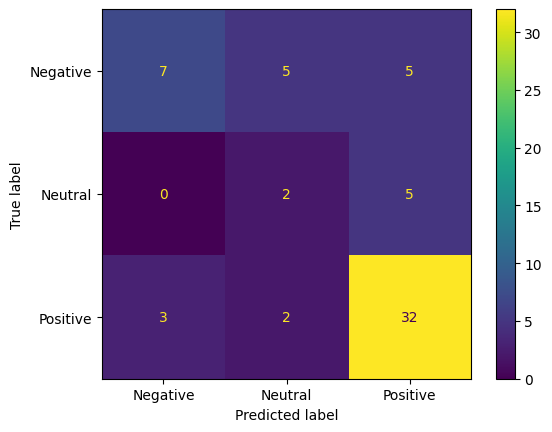

In [23]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, ConfusionMatrixDisplay

print(classification_report(y_test.argmax(1), y_pred.argmax(1)))
cm  = confusion_matrix(y_test.argmax(1), y_pred.argmax(1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot()
plt.show()

In [ ]:
actual = pd.DataFrame({"Actual label": y_test.argmax(1)})

In [ ]:
predicted = pd.DataFrame({"Predicted label": y_pred.argmax(1)})

In [ ]:
full_results = pd.concat([X_test, actual, predicted], axis = 1)

In [ ]:
full_results.loc[(full_results['Actual label'] == 2)& (full_results['Predicted label'] == 1)]

,Cleaned_Tweets,Actual label,Predicted label
2,fuel shortages create a massive shift towards ...,2,1
8,yellen biden committed to restoring incentives...,2,1
18,safety efficiency and zero tailpipe emissionse...,2,1
25,lthm395 was the bottom thus far depending on h...,2,1
35,there is so much antielectric vehicles propaga...,2,1
36,the bidenharris administration released an ele...,2,1
47,more drivers are interested in electric vehicl...,2,1
52,electric vehicles are better for the environme...,2,1
53,podcast tesla incredible production numbers gm...,2,1
